In [1]:
!pip install yfinance
!pip install prophet
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import yfinance as yf

#ML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from prophet import Prophet
from pmdarima import auto_arima 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# define the basic info needed
ticker = 'SPY'
start = '2020-01-01'
end = '2023-05-01'


# get stock data from yfinance and save it as a dataframe 
df = yf.download(tickers = ticker, start = start, end = end)

[*********************100%***********************]  1 of 1 completed


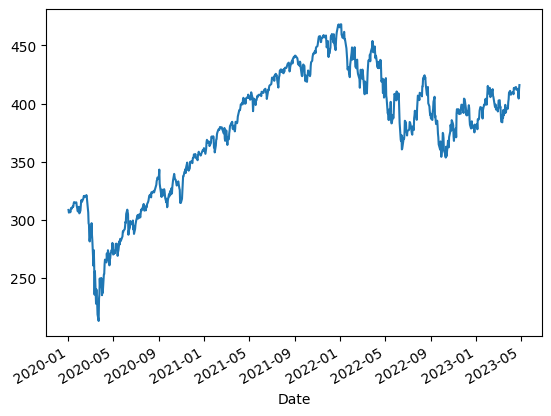

In [4]:
df['Adj Close'].plot();

# Linear Regression

In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# define features and label 
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Adj Close'].values

In [7]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 3)

In [8]:
# define the model and fit the data
regressionModel = LinearRegression()
regressionModel.fit(X_train, y_train)

LinearRegression()

In [9]:
# use the model to make predictions 
regressionPreds = regressionModel.predict(X_test)

In [10]:
# combine the actual and predicted values into one dataframe
dfRegression = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': regressionPreds.flatten()})

In [11]:
# calculate the mean absolute error
regressionMae = metrics.mean_absolute_error(dfRegression['Actual'], dfRegression['Predicted'])
print("The Mean Absolute Error for the regression model is: " + str(regressionMae))

The Mean Absolute Error for the regression model is: 3.3509334908067334


### The Mean Absolute Error to beat is 3.35

# ARIMA

In [12]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Adj Close'])
print(f'p-value: {adf_test[1]}')

p-value: 0.523162469285509


So, we cannot reject the null hypothesis

In [13]:
# split data into train and test sets
train = df[:-167]
test = df[-167:]

In [14]:
# we do not need the close column, so drop that 
train = train.drop('Close', axis=1)
test = test.drop('Close', axis=1)

features = ['Open', 'High', 'Low', 'Volume']

In [15]:
auto_arima(train['Adj Close'], seasonal=False,start_p=0, start_q=0, m=1,max_p=3, max_q=3, d=None, start_P=0, D=0,max_Q=4)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
# build and fit the model
arimaModel = ARIMA(endog=train['Adj Close'], exog=train[features], order=(2,1,0))
arimaFit = arimaModel.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# make predictions on the training set
train['Predictions'] = arimaFit.predict()

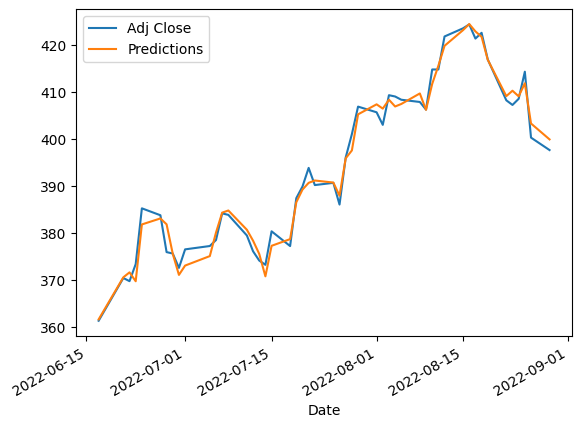

In [18]:
# plot the last 50 predictions vs actual values
train[['Adj Close', 'Predictions']][-50:].plot();

In [19]:
import warnings 
warnings.filterwarnings('ignore')

# predict the test set
arimaForecast = [arimaFit.forecast(exog=test[features].iloc[i]).values[0] for i in range(len(test))]
test['Forecast'] = arimaForecast

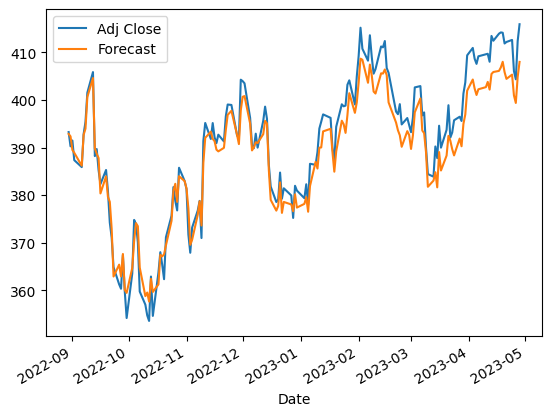

In [20]:
# plot the forecast vs the actual values for the test set
test[['Adj Close', 'Forecast']].plot();

In [21]:
# calculate the mean absolute error
arimaMae = metrics.mean_absolute_error(test['Adj Close'], test['Forecast'])
print("The Mean Absolute Error for the ARIMA model is: " + str(arimaMae))

The Mean Absolute Error for the ARIMA model is: 3.366083484775944


### The Mean Absolute Error of 3.36 is slightly worse than the regression model

# Prophet

In [22]:
# keep only the date and adj close columns 
dfProphet = df.reset_index()

dfProphet = dfProphet[['Date', 'Adj Close']]

# rename the columns
dfProphet.columns = ['ds', 'y']

In [23]:
# keep only the first 80% of the data for training, the rest is for testing 
dfProphetTrain = dfProphet[:-167]
dfProphetTest = dfProphet[-167:]

In [24]:
# train the model
prophet = Prophet(daily_seasonality = True)

prophet.fit(dfProphetTrain)

17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# make predictions 
prophetPreds = prophet.predict(dfProphetTest)

In [26]:
# add the predictions to the dataframe
dataProphet = pd.DataFrame({'Date': dfProphetTest['ds'], 'Actual': dfProphetTest['y']})
dataProphet = dataProphet.reset_index(drop=True)
predicted = pd.DataFrame(prophetPreds['yhat'])
dataProphet['Predicted'] = predicted['yhat']

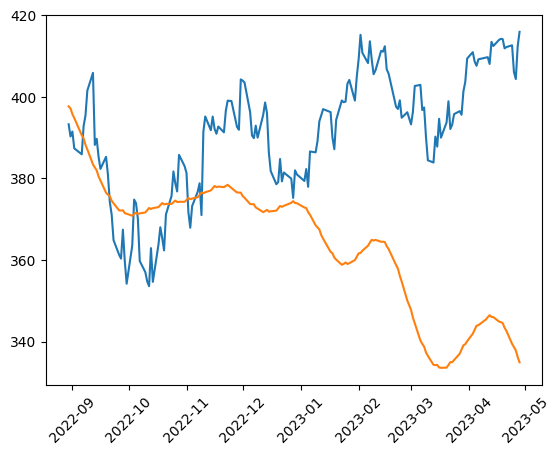

In [27]:
plt.plot(dataProphet['Date'], dataProphet['Actual']);
plt.plot(dataProphet['Date'], dataProphet['Predicted']);
plt.xticks(rotation=45);

In [28]:
# calculate the mean absolute error
prophetMae = metrics.mean_absolute_error(dataProphet['Actual'], dataProphet['Predicted'])
print("The Mean Absolute Error for the regression model is: " + str(prophetMae))

The Mean Absolute Error for the regression model is: 29.864590556519207


### The prophet model performed very poorly. This is due to the fact that the stock price was trending downwards when the data was split. The prophet model predicted that the price would continue to fall, whereas in reality the stock price rebounded.

17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing


The Mean Absolute Error for the regression model is: 9.902444350231953


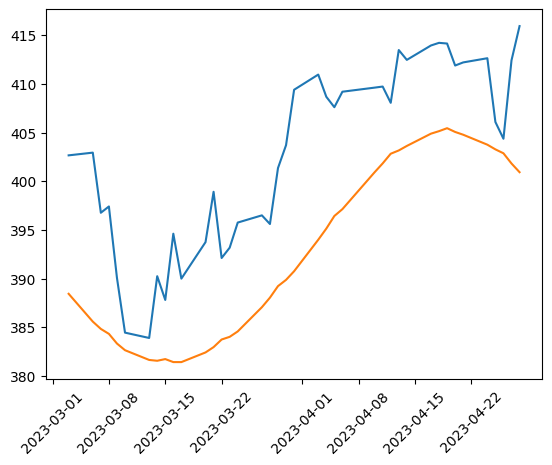

In [29]:
# keep the first 95% of the data for training, the rest is for testing 
dfProphetTrain = dfProphet[:-40]
dfProphetTest = dfProphet[-40:]

# train the model
prophet = Prophet(daily_seasonality = True)

prophet.fit(dfProphetTrain)

# make predictions 
prophetPreds = prophet.predict(dfProphetTest)

dataProphet = pd.DataFrame({'Date': dfProphetTest['ds'], 'Actual': dfProphetTest['y']})
dataProphet = dataProphet.reset_index(drop=True)
predicted = pd.DataFrame(prophetPreds['yhat'])
dataProphet['Predicted'] = predicted['yhat']

plt.plot(dataProphet['Date'], dataProphet['Actual']);
plt.plot(dataProphet['Date'], dataProphet['Predicted']);
plt.xticks(rotation=45);

# calculate the mean absolute error
prophetMae = metrics.mean_absolute_error(dataProphet['Actual'], dataProphet['Predicted'])
print("The Mean Absolute Error for the regression model is: " + str(prophetMae))

### Given more data for training, the model makes better predictions, but still worse than the linear and ARIMA models.

# LSTM

In [117]:
dfLSTM = df.drop('Close', axis=1)

In [118]:
# scale the data
scaler = MinMaxScaler()

# scaler.fit(dfLSTM[dfLSTM.columns])

# dfLSTM[dfLSTM.columns] = scaler.transform(dfLSTM[dfLSTM.columns])

dfLSTM = scaler.fit_transform(dfLSTM['Adj Close'].values.reshape(-1,1))

In [119]:
prediction_days = 30

X = []
y = []

for x in range(prediction_days, len(dfLSTM)):
    X.append(dfLSTM[x-prediction_days:x, 0])
    y.append(dfLSTM[x, 0])

X = np.array(X) 
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [110]:
# prepare the data 
window = 10

# array = dfLSTM.to_numpy()

X = []
y = []

for i in range(len(array)-window):
    row = [r for r in array[i:i+window]]
    
    X.append(row)
    label = array[i+window][0]
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [120]:
# split the data into training and testing sets
# we will use 80% for training 20% for testing 
X_train, y_train = X[:-167], y[:-167]

X_test, y_test = X[-167:], y[-167:]

In [121]:
# create the model
lstmModel = Sequential()

# input layer 
lstmModel.add(LSTM(units = 50, return_sequences =True, input_shape=(X_train.shape[1], 1)))
lstmModel.add(Dropout(.2))

lstmModel.add(LSTM(units=50, return_sequences=True))
lstmModel.add(Dropout(.2))

lstmModel.add(LSTM(units=50, return_sequences=False))
lstmModel.add(Dropout(.2))

# output 
lstmModel.add(Dense(units=1))

# compile 
lstmModel.compile(optimizer='adam', loss='mean_absolute_error', metrics = 'mean_absolute_error')

In [122]:
# train the model
lstmModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)

Epoch 1/25
20/20 [==============================] - 7s 104ms/step - loss: 0.2002 - mean_absolute_error: 0.2002 - val_loss: 0.0814 - val_mean_absolute_error: 0.0814
Epoch 2/25
20/20 [==============================] - 1s 38ms/step - loss: 0.0757 - mean_absolute_error: 0.0757 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 3/25
20/20 [==============================] - 1s 39ms/step - loss: 0.0675 - mean_absolute_error: 0.0675 - val_loss: 0.0466 - val_mean_absolute_error: 0.0466
Epoch 4/25
20/20 [==============================] - 1s 39ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417
Epoch 5/25
20/20 [==============================] - 1s 38ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426
Epoch 6/25
20/20 [==============================] - 1s 40ms/step - loss: 0.0648 - mean_absolute_error: 0.0648 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441
Epoch 7/25
20/20 [===

In [151]:
# make predictions 
lstmPreds = lstmModel.predict(X_test)

# reverse scale the data 
# lstmPreds = scaler.inverse_transform(lstmPreds)

# store predictions in a dataframe 
lstmResults = pd.DataFrame({'Predicted': np.concatenate(lstmPreds).tolist(), 'Actual': y_test.tolist()})
lstmResults['Date'] = dataProphet['Date']

6/6 [==============================] - 0s 13ms/step


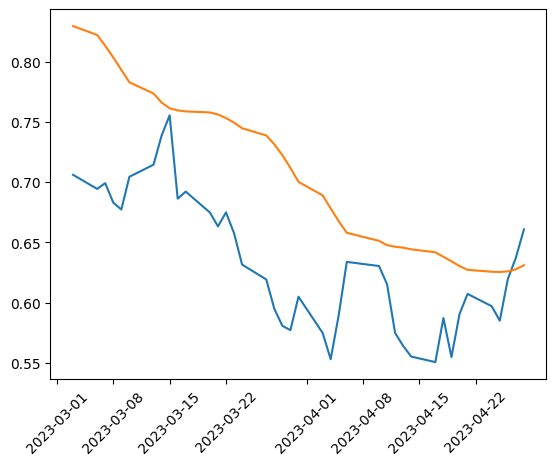

In [152]:
# plot the actual vs predicted
plt.plot(lstmResults['Date'], lstmResults['Actual']);
plt.plot(lstmResults['Date'], lstmResults['Predicted']);
plt.xticks(rotation=45);

In [144]:
# calculate the mean absolute error
lstmMae = metrics.mean_absolute_error(lstmResults['Predictions'], lstmResults['Actual'])
print("The Mean Absolute Error for the LSTM model is: " + str(lstmMae))

The Mean Absolute Error for the LSTM model is: 0.047444913265623966


## The LSTM provides the best Mean Absolute Error